# Importing Necessary Packages

In [210]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import snscrape.modules.twitter as sntwitter
from pathlib import Path  
import re
import string
from transformers import AutoTokenizer
#add package
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from textblob import TextBlob
from itertools import cycle, islice


In [211]:
# requirements 
# wordcloud
# scipy
# transformers
# tqdm
# matplotlib
# nltk
#textblob

# Importing Webscrapped and sentiment tagged data

In [212]:
vaccine_df_2020_2021 = pd.read_csv(r'data/vaccine_output_2020_2021.csv')
tagged_data_df = pd.read_csv(r'data/Sentiment_tagged.csv' , encoding= 'unicode_escape')
#Negative = 1, neutral = 2, positive = 3
#vaccine_df_2021_2022 = pd.read_csv(r'data/vaccine_output_2021_2022.csv')

# EDA and Sentiment Analysis on sentiment tagged data

We are using this step to analyze the performance of VADER , TEXT BLOB and Roberta and compare their algorithmic accuracy on sentiment tagged data,however manually tagging data is an impossible task and we need to find the optimal algorithm to with highest accuracy to find sentiment on the webscrapped data .

## EDA

In [213]:
tagged_data_df.head()

tweet_id  label                                         tweet_text
0  1.360342e+18      1  4,000 a day dying from the so called Covid-19 ...
1  1.382896e+18      2  Pranam message for today manifested in Dhyan b...
2  1.375673e+18      2  Hyderabad-based ?@BharatBiotech? has sought fu...
3  1.381311e+18      1  Confirmation that Chinese #vaccines "dont hav...
4  1.362166e+18      3  Lab studies suggest #Pfizer, #Moderna vaccines...

In [214]:
tagged_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tweet_id    6000 non-null   float64
 1   label       6000 non-null   int64  
 2   tweet_text  6000 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 140.8+ KB


In [215]:
print(tagged_data_df.shape)

(6000, 3)


In [216]:
tagged_data_df.isna().sum()

tweet_id      0
label         0
tweet_text    0
dtype: int64

## Preprocessing 

In [217]:
# clean and filter using SPARK
def preprocessing(df):

    tweet_lower_df = df['tweet_text'].str.lower()
    EMOJI_PATTERN = re.compile( \
                           "[" \
                           "\U0001F1E0-\U0001F1FF"  \
                           "\U0001F300-\U0001F5FF"  \
                           "\U0001F600-\U0001F64F"  \
                           "\U0001F680-\U0001F6FF"  \
                           "\U0001F700-\U0001F77F" \
                           "\U0001F780-\U0001F7FF" \
                           "\U0001F800-\U0001F8FF" \
                           "\U0001F900-\U0001F9FF" \
                           "\U0001FA00-\U0001FA6F" \
                           "\U0001FA70-\U0001FAFF" \
                           "\U00002702-\U000027B0" \
                           "\U000024C2-\U0001F251" \
                           "]+")
    
    tweet_whitespace_df = tweet_lower_df.replace(r'\s+',' ',regex=True)
    #tweet_emoji_df = tweet_whitespace_df.replace(EMOJI_PATTERN,'',regex = True)
    tweet_hashtag_df = tweet_whitespace_df.replace(r'#','',regex=True)
    tweet_numbers_df = tweet_hashtag_df.replace(r'[0-9]+', '', regex = True)
    tweet_amp_df = tweet_numbers_df.replace(r'&amp;', '', regex = True)
    tweet_reply_df = tweet_amp_df.replace(r'@[^\s]+', '', regex = True)
    tweet_punc_df = tweet_numbers_df.replace(r'[^\w\s]', '', regex = True)

    return tweet_punc_df


In [218]:
tagged_data_cleaned_df = tagged_data_df
tagged_data_cleaned_df['Processed_Tweet'] = preprocessing(tagged_data_df)
tagged_data_cleaned_df.head()

tweet_id  label                                         tweet_text  \
0  1.360342e+18      1  4,000 a day dying from the so called Covid-19 ...   
1  1.382896e+18      2  Pranam message for today manifested in Dhyan b...   
2  1.375673e+18      2  Hyderabad-based ?@BharatBiotech? has sought fu...   
3  1.381311e+18      1  Confirmation that Chinese #vaccines "dont hav...   
4  1.362166e+18      3  Lab studies suggest #Pfizer, #Moderna vaccines...   

                                     Processed_Tweet  
0   a day dying from the so called covid vaccine ...  
1  pranam message for today manifested in dhyan b...  
2  hyderabadbased bharatbiotech has sought funds ...  
3  confirmation that chinese vaccines dont have v...  
4  lab studies suggest pfizer moderna vaccines ca...

In [219]:
#change labels 
#Negative = 1, neutral = 2, positive = 3
tagged_clean_df = tagged_data_cleaned_df
tagged_clean_df['sentiment'] = tagged_data_cleaned_df['label'].apply(lambda x : 'neg' if x== 1 else \
                                                                     ('neu' if x == 2  else 'pos'))
tagged_clean_df['ID'] = tagged_data_cleaned_df.index

(-0.5, 399.5, 199.5, -0.5)

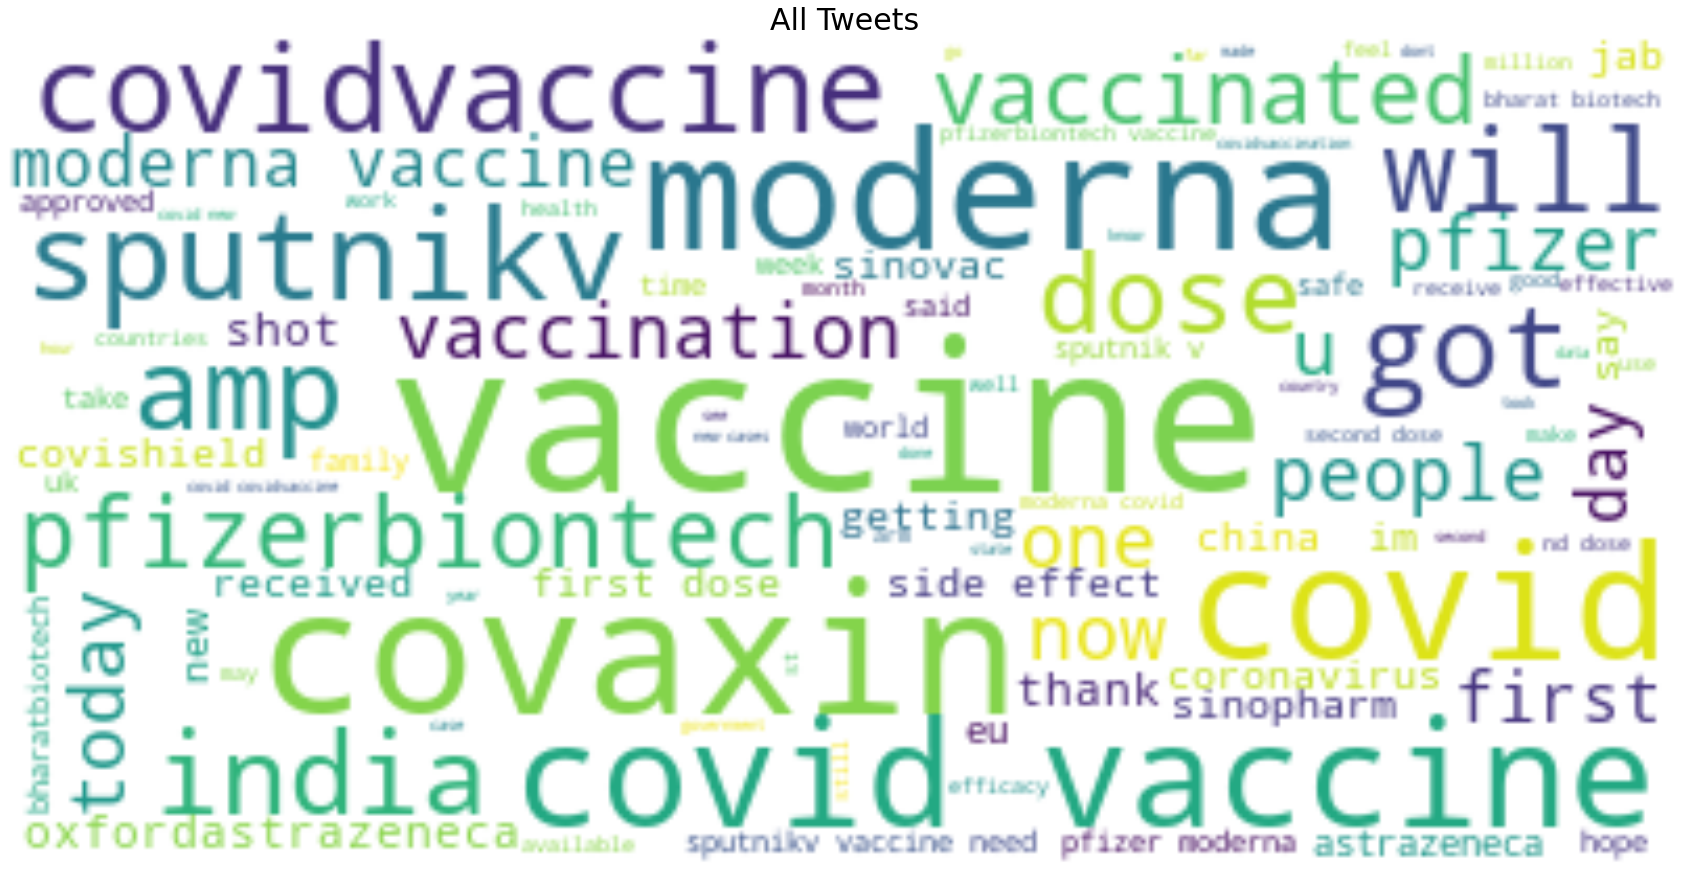

In [220]:

tweet_All = " ".join(tweet for tweet in tagged_clean_df['Processed_Tweet'])

fig, ax = plt.subplots(1, 1, figsize  = (30,30))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)


# Display the generated image:
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.set_title('All Tweets', fontsize=30)
ax.axis('off')

In [221]:
Sentiment_analyzer = SentimentIntensityAnalyzer()

In [222]:
def TextBlob_score(tweet):
    # This polarity score is between -1 to 1
    polarity = TextBlob(tweet).sentiment.polarity
    if polarity < 0:
        sentiment = 'neg'
    elif polarity == 0:
        sentiment = 'neu'
    else:
        sentiment = 'pos'

    return polarity,sentiment
def TextBlob_subjectivity(tweet):
    
    subjectivity = TextBlob(tweet).sentiment.subjectivity
    return subjectivity

In [223]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [224]:
def roberta_polarity_scores(sample):
    encoded = tokenizer(sample,return_tensors='pt')
    output = model(**encoded)
    scores=output[0][0].detach().numpy()
    softmax_scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : softmax_scores[0],
        'roberta_neu' : softmax_scores[1],
        'roberta_pos' : softmax_scores[2]
    }
    return scores_dict


In [225]:
#iterate over the dataset to calculate scores for each example
# some size of the text is too big for the roberta model to handle , we can skip those by adding try
result = {}
final_result={}
for i,row in tqdm(tagged_clean_df.iterrows(),total=len(tagged_clean_df)):
    try:
        tweet = row['Processed_Tweet']
        id = row['ID']

        vader_result = Sentiment_analyzer.polarity_scores(tweet)
        score = TextBlob(tweet).sentiment.polarity
        subjectivity = TextBlob(tweet).sentiment.subjectivity
        if score < 0:
            sentiment = 'neg'
        elif score == 0:
            sentiment = 'neu'
        else:
            sentiment = 'pos'
        
        vader_result_rename = {}
        for key , value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        

        roberta_result = roberta_polarity_scores(tweet)
        
        text_blob_result = {}
        Text_Blob_result = {'Text_blob_score' :score , 'Text_blob_subjectivity' :subjectivity,'Text_blob_sentiment' : sentiment}


        #combining three dictionaries
        combined_result = {**vader_result,**roberta_result,**Text_Blob_result}
        #break
        result[id] = combined_result
    except RuntimeError:
        print(f'Text size too long for id: {id}')


  0%|          | 0/6000 [00:00<?, ?it/s]

In [226]:
Tagged_Final =  pd.DataFrame(result).T
#Tweet_Roberta
Tagged_Final['ID'] = Tagged_Final.index


In [227]:
Tagged_Final = tagged_clean_df.merge(Tagged_Final,how = 'left')
Tagged_Final.head()

tweet_id  label                                         tweet_text  \
0  1.360342e+18      1  4,000 a day dying from the so called Covid-19 ...   
1  1.382896e+18      2  Pranam message for today manifested in Dhyan b...   
2  1.375673e+18      2  Hyderabad-based ?@BharatBiotech? has sought fu...   
3  1.381311e+18      1  Confirmation that Chinese #vaccines "dont hav...   
4  1.362166e+18      3  Lab studies suggest #Pfizer, #Moderna vaccines...   

                                     Processed_Tweet sentiment  ID    neg  \
0   a day dying from the so called covid vaccine ...       neg   0    0.0   
1  pranam message for today manifested in dhyan b...       neu   1    0.0   
2  hyderabadbased bharatbiotech has sought funds ...       neu   2    0.0   
3  confirmation that chinese vaccines dont have v...       neg   3  0.199   
4  lab studies suggest pfizer moderna vaccines ca...       pos   4    0.0   

     neu    pos compound roberta_neg roberta_neu roberta_pos Text_blob_score  \
0    1.0    0.0      0.0    0.887989    0.107061     0.00495             0.0   
1  0.794  0.206   0.7579    0.010037    0.668526    0.321437            0.45   
2    1.0    0.0      0.0    0.016676    0.895794     0.08753             0.1   
3  0.801    0.0  -0.8484    0.879123    0.116093    0.004785          0.0145   
4  0.794  0.206   0.3818      0.0104    0.529905    0.459695             0.0   

  Text_blob_subjectivity Text_blob_sentiment  
0                    0.0                 neu  
1                   0.65                 pos  
2                    0.3                 pos  
3                 0.2505                 pos  
4                    0.0                 neu

In [228]:
Tagged_Final['Vader_Sentiment_Score'] =  Tagged_Final[["neg", "neu","pos"]].max(axis=1)
Tagged_Final_sentiment = Tagged_Final


In [229]:
Tagged_Final_sentiment["neg"] = pd.to_numeric(Tagged_Final_sentiment["neg"])
Tagged_Final_sentiment["pos"] = pd.to_numeric(Tagged_Final_sentiment["pos"])
Tagged_Final_sentiment["neu"] = pd.to_numeric(Tagged_Final_sentiment["neu"])
Tagged_Final_sentiment["compound"] = pd.to_numeric(Tagged_Final_sentiment["compound"])
Tagged_Final_sentiment["roberta_neg"] = pd.to_numeric(Tagged_Final_sentiment["roberta_neg"])
Tagged_Final_sentiment["roberta_pos"] = pd.to_numeric(Tagged_Final_sentiment["roberta_pos"])
Tagged_Final_sentiment["roberta_neu"] = pd.to_numeric(Tagged_Final_sentiment["roberta_neu"])
Tagged_Final_sentiment['Vader_Sentiment'] = Tagged_Final_sentiment[["neg", "neu","pos"]].idxmax(axis=1)
Tagged_Final_sentiment.head()

tweet_id  label                                         tweet_text  \
0  1.360342e+18      1  4,000 a day dying from the so called Covid-19 ...   
1  1.382896e+18      2  Pranam message for today manifested in Dhyan b...   
2  1.375673e+18      2  Hyderabad-based ?@BharatBiotech? has sought fu...   
3  1.381311e+18      1  Confirmation that Chinese #vaccines "dont hav...   
4  1.362166e+18      3  Lab studies suggest #Pfizer, #Moderna vaccines...   

                                     Processed_Tweet sentiment  ID    neg  \
0   a day dying from the so called covid vaccine ...       neg   0  0.000   
1  pranam message for today manifested in dhyan b...       neu   1  0.000   
2  hyderabadbased bharatbiotech has sought funds ...       neu   2  0.000   
3  confirmation that chinese vaccines dont have v...       neg   3  0.199   
4  lab studies suggest pfizer moderna vaccines ca...       pos   4  0.000   

     neu    pos  compound  roberta_neg  roberta_neu  roberta_pos  \
0  1.000  0.000    0.0000     0.887989     0.107061     0.004950   
1  0.794  0.206    0.7579     0.010037     0.668526     0.321437   
2  1.000  0.000    0.0000     0.016676     0.895794     0.087530   
3  0.801  0.000   -0.8484     0.879123     0.116093     0.004785   
4  0.794  0.206    0.3818     0.010400     0.529905     0.459695   

  Text_blob_score Text_blob_subjectivity Text_blob_sentiment  \
0             0.0                    0.0                 neu   
1            0.45                   0.65                 pos   
2             0.1                    0.3                 pos   
3          0.0145                 0.2505                 pos   
4             0.0                    0.0                 neu   

   Vader_Sentiment_Score Vader_Sentiment  
0                  1.000             neu  
1                  0.794             neu  
2                  1.000             neu  
3                  0.801             neu  
4                  0.794             neu

In [230]:
Tagged_Final_sentiment['Roberta_Sentiment_Score'] =  Tagged_Final_sentiment[["roberta_neg", "roberta_neu","roberta_pos"]].max(axis=1)
Tagged_Final_sentiment_1 = Tagged_Final_sentiment
Tagged_Final_sentiment_1['Roberta_Sentiment'] = Tagged_Final_sentiment[["roberta_neg", "roberta_neu","roberta_pos"]].idxmax(axis=1)


In [231]:
Tagged_Final_sentiment_1['Roberta_Sentiment'] = Tagged_Final_sentiment_1['Roberta_Sentiment'].apply(lambda x : 'neg' if x== 'roberta_neg' else \
                                                                     ('neu' if x == 'roberta_neu'  else 'pos'))

In [232]:
final_sentiment_counts = Tagged_Final_sentiment_1.groupby(['sentiment']).size()
print(final_sentiment_counts)


sentiment
neg     420
neu    3680
pos    1900
dtype: int64


In [233]:
vader_tagged_sentiment_counts = Tagged_Final_sentiment_1.groupby(['Vader_Sentiment']).size()
print(vader_tagged_sentiment_counts)


Vader_Sentiment
neg       4
neu    5971
pos      25
dtype: int64


In [234]:
blob_tagged_sentiment_counts = Tagged_Final_sentiment_1.groupby(['Text_blob_sentiment']).size()
print(blob_tagged_sentiment_counts)

Text_blob_sentiment
neg     887
neu    2086
pos    3027
dtype: int64


In [235]:
BERT_tagged_sentiment_counts = Tagged_Final_sentiment_1.groupby(['Roberta_Sentiment']).size()
print(BERT_tagged_sentiment_counts)

Roberta_Sentiment
neg    1206
neu    3524
pos    1270
dtype: int64


In [236]:
fig = plt.figure(figsize=(18,10), dpi=1600)
#2 rows 2 columns

#first row, first column
ax1 = plt.subplot2grid((2,2),(0,0))
final_sentiment_counts.plot.pie(ax=ax1, autopct='%1.1f%%', startangle=270, fontsize=12, label="")
plt.title('Manually Tagged Sentiment')

#first row sec column
ax1 = plt.subplot2grid((2,2), (0, 1))
vader_tagged_sentiment_counts.plot.pie(ax=ax1, autopct='%1.1f%%', startangle=270, fontsize=12, label="")
plt.title('Vader Sentiment')

#Second row first column
ax1 = plt.subplot2grid((2,2), (1, 0))
blob_tagged_sentiment_counts.plot.pie(ax=ax1, autopct='%1.1f%%', startangle=270, fontsize=12, label="")
plt.title('Text Blob')

#second row second column
ax1 = plt.subplot2grid((2,2), (1, 1))
BERT_tagged_sentiment_counts.plot.pie(ax=ax1, autopct='%1.1f%%', startangle=270, fontsize=12, label="")
plt.title('RoBERTa')



Text(0.5, 1.0, 'RoBERTa')

In [237]:
# change to single metric 


In [238]:
from sklearn import metrics

# True values
y_true = Tagged_Final_sentiment_1['sentiment']
# Predicted values
y_pred_vader = Tagged_Final_sentiment_1['Vader_Sentiment']
y_pred_blob = Tagged_Final_sentiment_1['Text_blob_sentiment']
y_pred_bert = Tagged_Final_sentiment_1['Roberta_Sentiment']

print('\n ######### VADER CONFUSION MATRIX ######### \n') 
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred_vader))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred_vader, digits=3))


 ######### VADER CONFUSION MATRIX ######### 

[[   2  418    0]
 [   1 3671    8]
 [   1 1882   17]]
              precision    recall  f1-score   support

         neg      0.500     0.005     0.009       420
         neu      0.615     0.998     0.761      3680
         pos      0.680     0.009     0.018      1900

    accuracy                          0.615      6000
   macro avg      0.598     0.337     0.263      6000
weighted avg      0.627     0.615     0.473      6000



In [239]:
print('\n ######### TEXT BLOB CONFUSION MATRIX ######### \n') 

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred_blob))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred_blob, digits=3))


 ######### TEXT BLOB CONFUSION MATRIX ######### 

[[ 130  111  179]
 [ 597 1430 1653]
 [ 160  545 1195]]
              precision    recall  f1-score   support

         neg      0.147     0.310     0.199       420
         neu      0.686     0.389     0.496      3680
         pos      0.395     0.629     0.485      1900

    accuracy                          0.459      6000
   macro avg      0.409     0.442     0.393      6000
weighted avg      0.556     0.459     0.472      6000



In [240]:
print('\n ######### roBERTa CONFUSION MATRIX ######### \n') 

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred_bert))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred_bert, digits=3))


 ######### roBERTa CONFUSION MATRIX ######### 

[[ 281  126   13]
 [ 749 2553  378]
 [ 176  845  879]]
              precision    recall  f1-score   support

         neg      0.233     0.669     0.346       420
         neu      0.724     0.694     0.709      3680
         pos      0.692     0.463     0.555      1900

    accuracy                          0.619      6000
   macro avg      0.550     0.608     0.536      6000
weighted avg      0.680     0.619     0.635      6000



We can see that the accuracy of VADER and Roberta is higher than the text blob , Since its a multiclass classification it is hard to derive ROC curve . we can use OvR or OvO .

OvR — One vs Rest
OvR stands for “One vs Rest”, and as the name suggests is one method to evaluate multiclass models by comparing each class against all the others at the same time. In this scenario we take one class and consider it as our “positive” class, while all the others (the rest) are considered as the “negative” class.

OvO — One vs One
Now as you might imagine, OvO stands for “One vs One” and is really similar to OvR, but instead of comparing each class with the rest, we compare all possible two-class combinations of the dataset.

# EDA and Sentiment Analysis on webscrapped Data

## Exploratory Data Analysis

In [241]:
vaccine_df_2020_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  996 non-null    int64 
 1   Date        996 non-null    object
 2   User        996 non-null    object
 3   Tweet       996 non-null    object
 4   Tweet_URL   996 non-null    object
 5   Location    785 non-null    object
dtypes: int64(1), object(5)
memory usage: 46.8+ KB


In [242]:
print(vaccine_df_2020_2021.shape)

(996, 6)


In [243]:
vaccine_df_2020_2021.head()

Unnamed: 0                       Date          User  \
0           0  2021-12-07 23:58:57+00:00    TPedherney   
1           1  2021-12-07 23:32:39+00:00    cwillits30   
2           2  2021-12-07 23:29:36+00:00       MA_CEAL   
3           3  2021-12-07 23:08:19+00:00     WebAeneas   
4           4  2021-12-07 23:02:41+00:00  TheAmirImani   

                                               Tweet  \
0  In line to get my booster #vaccine #Booster #P...   
1  Officially boosted! First done of Moderna afte...   
2  #COVIDMythBustingTuesdays! Myth: Doesn’t the #...   
3  #vaccinated another great idea you can sue any...   
4  I don't know if this is a "3 dose #vaccine" or...   

                                           Tweet_URL               Location  
0  https://twitter.com/TPedherney/status/14683694...         Burlington, ON  
1  https://twitter.com/cwillits30/status/14683628...            Phoenix, AZ  
2  https://twitter.com/MA_CEAL/status/14683620841...  Boston, Massachusetts  
3  https://twitter.com/WebAeneas/status/146835672...                    NaN  
4  https://twitter.com/TheAmirImani/status/146835...                Toronto

In [244]:
vaccine_df_2020_2021.isna().sum()

Unnamed: 0      0
Date            0
User            0
Tweet           0
Tweet_URL       0
Location      211
dtype: int64

In [245]:
vaccine_df_2020_2021['Date'] = pd.to_datetime(vaccine_df_2020_2021['Date']).dt.date  #converting date column to date format
vaccine_df_2020_2021.head()

Unnamed: 0        Date          User  \
0           0  2021-12-07    TPedherney   
1           1  2021-12-07    cwillits30   
2           2  2021-12-07       MA_CEAL   
3           3  2021-12-07     WebAeneas   
4           4  2021-12-07  TheAmirImani   

                                               Tweet  \
0  In line to get my booster #vaccine #Booster #P...   
1  Officially boosted! First done of Moderna afte...   
2  #COVIDMythBustingTuesdays! Myth: Doesn’t the #...   
3  #vaccinated another great idea you can sue any...   
4  I don't know if this is a "3 dose #vaccine" or...   

                                           Tweet_URL               Location  
0  https://twitter.com/TPedherney/status/14683694...         Burlington, ON  
1  https://twitter.com/cwillits30/status/14683628...            Phoenix, AZ  
2  https://twitter.com/MA_CEAL/status/14683620841...  Boston, Massachusetts  
3  https://twitter.com/WebAeneas/status/146835672...                    NaN  
4  https://twitter.com/TheAmirImani/status/146835...                Toronto

### Visualising Tweet Count vs Location  

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'United States'),
  Text(1, 0, 'London, England'),
  Text(2, 0, 'Canada'),
  Text(3, 0, 'UK'),
  Text(4, 0, 'England, United Kingdom'),
  Text(5, 0, 'India'),
  Text(6, 0, 'United Kingdom'),
  Text(7, 0, 'South Africa'),
  Text(8, 0, 'Chicago, IL'),
  Text(9, 0, 'Washington, DC'),
  Text(10, 0, 'Ottawa, Ontario'),
  Text(11, 0, 'Earth'),
  Text(12, 0, 'New Delhi, India'),
  Text(13, 0, 'New York, NY'),
  Text(14, 0, 'Los Angeles, CA'),
  Text(15, 0, 'Free CH Resources'),
  Text(16, 0, 'Pretoria, South Africa'),
  Text(17, 0, 'Scotland'),
  Text(18, 0, 'Engadine'),
  Text(19, 0, 'Mumbai, India')])

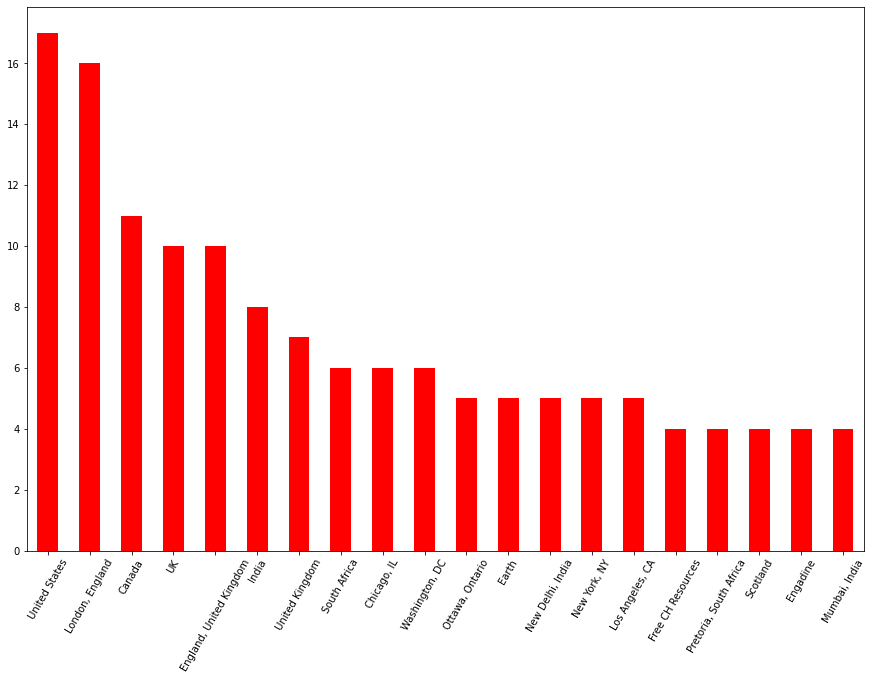

In [246]:
 
plt.figure(figsize=(15,10))
vaccine_df_2020_2021['Location'].value_counts().nlargest(20).plot(kind='bar', color="red")
plt.xticks(rotation=60)

- This information is not accurate as the locations are user generated and the same country has different formats such as "United Kingdom", "UK", "England" 
- Each location could either be a combination of country or country and city

## PREPROCESSING TWEETS

In [247]:
lemma = nltk.stem.WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')
print(stop_words)



['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [248]:
sample = "I am not very happy about the vaccination"
tokens = nltk.tokenize.word_tokenize(sample.lower())
words = [t for t in tokens if t not in stop_words]
lemmatize = [lemma.lemmatize(w) for w in words]
print(words)

['happy', 'vaccination']


"I am not very happy about the vacination" is a negative sentance , the nltk stopwords contain words negative and positive words in its stopwords corpus . removing the stop words using this would affect our sentiment analysis . Since the given sentance carries a negative sentiment but after lemmatizing it we get a positive words.

In [249]:
# clean and filter using SPARK
def preprocessing(df):
    location_df = df['Location']
    #tweet_lower_df = df['Tweet'].str.lower()
    EMOJI_PATTERN = re.compile( \
                           "[" \
                           "\U0001F1E0-\U0001F1FF"  \
                           "\U0001F300-\U0001F5FF"  \
                           "\U0001F600-\U0001F64F"  \
                           "\U0001F680-\U0001F6FF"  \
                           "\U0001F700-\U0001F77F" \
                           "\U0001F780-\U0001F7FF" \
                           "\U0001F800-\U0001F8FF" \
                           "\U0001F900-\U0001F9FF" \
                           "\U0001FA00-\U0001FA6F" \
                           "\U0001FA70-\U0001FAFF" \
                           "\U00002702-\U000027B0" \
                           "\U000024C2-\U0001F251" \
                           "]+")
    
    tweet_whitespace_df = df['Tweet'].replace(r'\s+',' ',regex=True)
    #tweet_emoji_df = tweet_whitespace_df.replace(EMOJI_PATTERN,'',regex = True)
    tweet_hashtag_df = tweet_whitespace_df.replace(r'#','',regex=True)
    tweet_numbers_df = tweet_hashtag_df.replace(r'[0-9]+', '', regex = True)
    tweet_amp_df = tweet_numbers_df.replace(r'&amp;', '', regex = True)
    tweet_reply_df = tweet_amp_df.replace(r'@[^\s]+', '', regex = True)
    
    #tweet_punc_df = tweet_numbers_df.replace(r'[^\w\s]', '', regex = True)
    
    
    location_whitespace_df =  location_df.replace(r'\s+',' ',regex=True)
    location_hashtag_df = location_whitespace_df.replace(r'#','',regex=True)
    location_numbers_df = location_hashtag_df.replace(r'[0-9]+','',regex=True)
    location_emoji_df = location_numbers_df.replace(EMOJI_PATTERN,'',regex = True)
    PUNCT_MODIFIED = r'[.|!|#|\"|$|%|\'|\(|\)|*|+|=|<|>|~|\{|\}|\\|/|:|;|\?|@|\[|^|_|\`|\]]'
    location_punc_df = location_emoji_df.replace(PUNCT_MODIFIED,'',regex = True)
    return tweet_reply_df,location_punc_df


In [250]:
vaccine_20_21_cleanedDF = vaccine_df_2020_2021
vaccine_20_21_cleanedDF['Processed_Tweet'],vaccine_20_21_cleanedDF['Location'] = preprocessing(vaccine_df_2020_2021)
vaccine_20_21_cleanedDF['Location'] = vaccine_20_21_cleanedDF['Location'].fillna('')
vaccine_20_21_cleanedDF

Unnamed: 0        Date           User  \
0             0  2021-12-07     TPedherney   
1             1  2021-12-07     cwillits30   
2             2  2021-12-07        MA_CEAL   
3             3  2021-12-07      WebAeneas   
4             4  2021-12-07   TheAmirImani   
..          ...         ...            ...   
991         995  2021-12-04  AnoopChathoth   
992         996  2021-12-04    nemahinemla   
993         997  2021-12-04    DonielOediv   
994         998  2021-12-04  billlionnaire   
995         999  2021-12-04   ashifrazaiyc   

                                                 Tweet  \
0    In line to get my booster #vaccine #Booster #P...   
1    Officially boosted! First done of Moderna afte...   
2    #COVIDMythBustingTuesdays! Myth: Doesn’t the #...   
3    #vaccinated another great idea you can sue any...   
4    I don't know if this is a "3 dose #vaccine" or...   
..                                                 ...   
991  #Kerala has 1707 teaching and non teaching sta...   
992  Nisqually Indian Tribe mandates #CovidVaccine ...   
993  i feel like throwing up 52 hours after taking ...   
994  What Covid denial don't get it. They have had ...   
995  All The Health Workers In India Should Be Give...   

                                             Tweet_URL  \
0    https://twitter.com/TPedherney/status/14683694...   
1    https://twitter.com/cwillits30/status/14683628...   
2    https://twitter.com/MA_CEAL/status/14683620841...   
3    https://twitter.com/WebAeneas/status/146835672...   
4    https://twitter.com/TheAmirImani/status/146835...   
..                                                 ...   
991  https://twitter.com/AnoopChathoth/status/14669...   
992  https://twitter.com/nemahinemla/status/1466985...   
993  https://twitter.com/DonielOediv/status/1466984...   
994  https://twitter.com/billlionnaire/status/14669...   
995  https://twitter.com/ashifrazaiyc/status/146698...   

                       Location  \
0                Burlington, ON   
1                   Phoenix, AZ   
2         Boston, Massachusetts   
3                                 
4                       Toronto   
..                          ...   
991  Bangalore  Kannur  Wayanad   
992                   Nisqually   
993                          nz   
994                               
995          Rajgangpur, odisha   

                                       Processed_Tweet  
0     In line to get my booster vaccine Booster Pfizer  
1    Officially boosted! First done of Moderna afte...  
2    COVIDMythBustingTuesdays! Myth: Doesn’t the CO...  
3    vaccinated another great idea you can sue anyo...  
4    I don't know if this is a " dose vaccine" or a...  
..                                                 ...  
991  Kerala has  teaching and non teaching staff wh...  
992  Nisqually Indian Tribe mandates CovidVaccine f...  
993  i feel like throwing up  hours after taking se...  
994  What Covid denial don't get it. They have had ...  
995  All The Health Workers In India Should Be Give...  

[996 rows x 7 columns]

In [251]:
#Rearrange columns
col_list = vaccine_20_21_cleanedDF.columns.tolist()
cols = col_list[:-3] + col_list[-1:] + col_list[4:6]
vaccine_20_21_cleanedDF = vaccine_20_21_cleanedDF[cols]
vaccine_20_21_cleanedDF = vaccine_20_21_cleanedDF.rename({'Unnamed: 0': 'ID'}, axis=1) 
vaccine_20_21_cleanedDF.columns.tolist()

['ID', 'Date', 'User', 'Tweet', 'Processed_Tweet', 'Tweet_URL', 'Location']

In [252]:
vaccine_20_21_cleanedDF.to_csv(r'data/new_processed.csv', encoding='utf-8')

In [253]:
vaccine_20_21_cleanedDF.head()

ID        Date          User  \
0   0  2021-12-07    TPedherney   
1   1  2021-12-07    cwillits30   
2   2  2021-12-07       MA_CEAL   
3   3  2021-12-07     WebAeneas   
4   4  2021-12-07  TheAmirImani   

                                               Tweet  \
0  In line to get my booster #vaccine #Booster #P...   
1  Officially boosted! First done of Moderna afte...   
2  #COVIDMythBustingTuesdays! Myth: Doesn’t the #...   
3  #vaccinated another great idea you can sue any...   
4  I don't know if this is a "3 dose #vaccine" or...   

                                     Processed_Tweet  \
0   In line to get my booster vaccine Booster Pfizer   
1  Officially boosted! First done of Moderna afte...   
2  COVIDMythBustingTuesdays! Myth: Doesn’t the CO...   
3  vaccinated another great idea you can sue anyo...   
4  I don't know if this is a " dose vaccine" or a...   

                                           Tweet_URL               Location  
0  https://twitter.com/TPedherney/status/14683694...         Burlington, ON  
1  https://twitter.com/cwillits30/status/14683628...            Phoenix, AZ  
2  https://twitter.com/MA_CEAL/status/14683620841...  Boston, Massachusetts  
3  https://twitter.com/WebAeneas/status/146835672...                         
4  https://twitter.com/TheAmirImani/status/146835...                Toronto

(-0.5, 399.5, 199.5, -0.5)

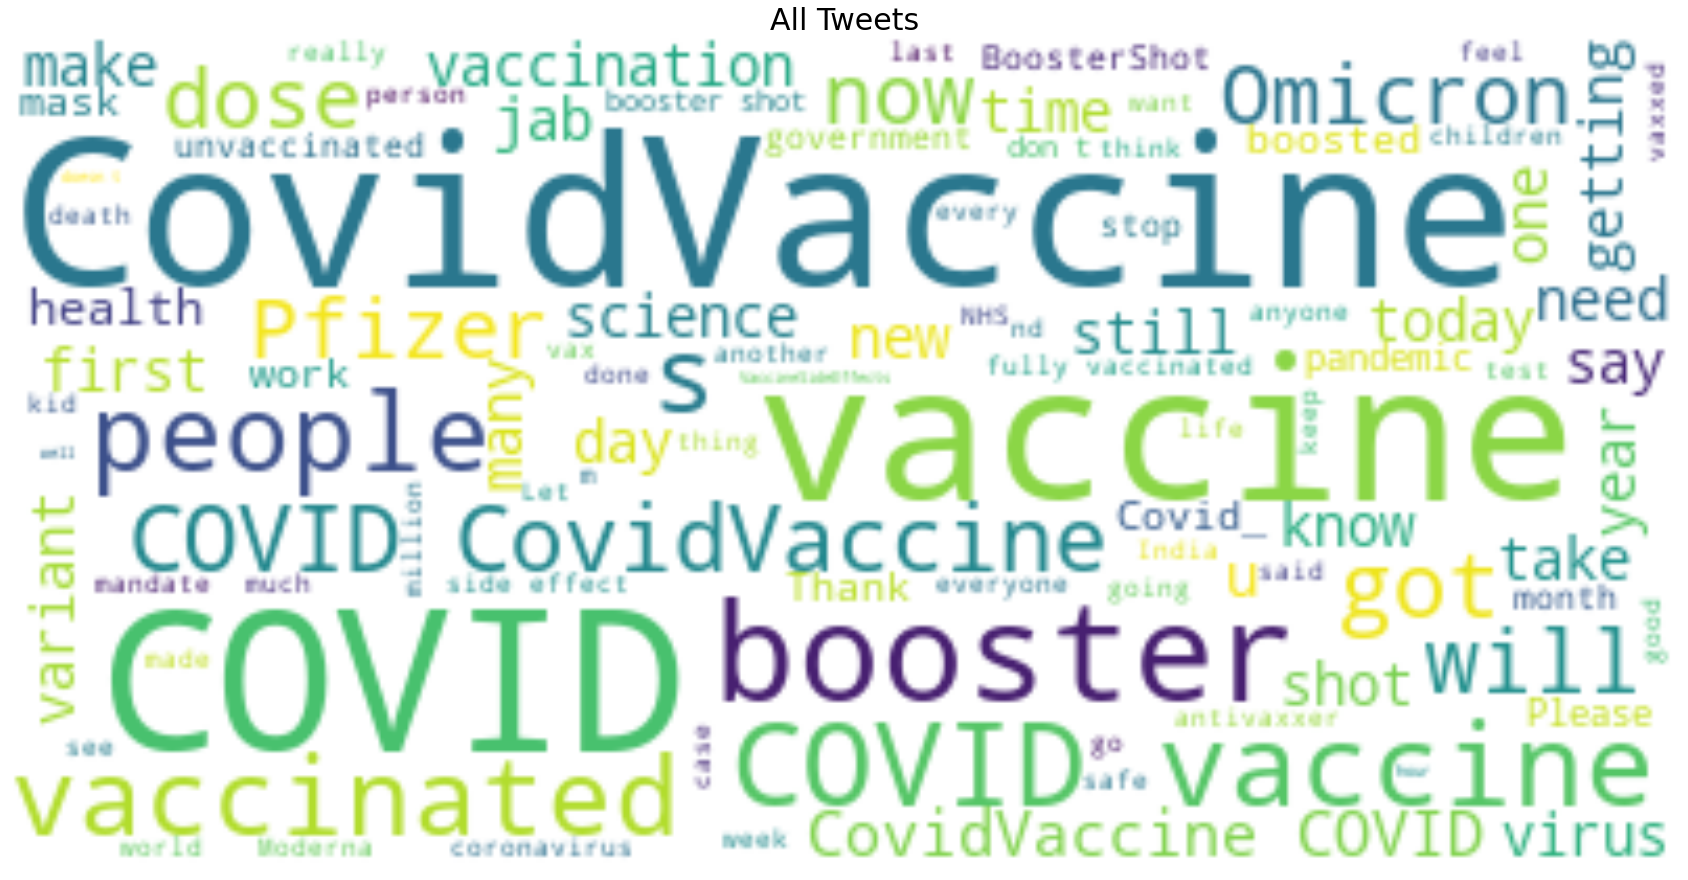

In [254]:

tweet_All = " ".join(review for review in vaccine_20_21_cleanedDF['Processed_Tweet'])

fig, ax = plt.subplots(1, 1, figsize  = (30,30))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)


# Display the generated image:
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.set_title('All Tweets', fontsize=30)
ax.axis('off')


The Most Frequent words are 'CovidVaccine , Covid , Virus , Omicron ' Occurs almost in all the sentances , this along with the stop words wouldnt affect the performance of algorithms but words like Pfizer Moderna can help us determine the popular vaccine , and words such as "side effect  , death " can help us tag misinformed tweets about covid vaccine 

## ALGORITHMS ( VADER , TEXTBLOB AND RoBERTa)

#### Basic NLTK Operations

In [255]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/preethi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [256]:
sample = vaccine_20_21_cleanedDF['Processed_Tweet'][1]
print(sample)

#VADER 
#ROBERTA
#Compare and visualize 
#Pipeline for current tweet

Officially boosted! First done of Moderna after my original  doses of Pfizer! Let’s do this! covid booster COVIDBooster covid pfizer moderna


In [257]:
from nltk.tokenize import TweetTokenizer

tokens = TweetTokenizer().tokenize(sample)
print(tokens)

['Officially', 'boosted', '!', 'First', 'done', 'of', 'Moderna', 'after', 'my', 'original', 'doses', 'of', 'Pfizer', '!', 'Let', '’', 's', 'do', 'this', '!', 'covid', 'booster', 'COVIDBooster', 'covid', 'pfizer', 'moderna']


In [258]:
tagged = nltk.pos_tag(tokens)
print(tagged)

[('Officially', 'RB'), ('boosted', 'VBD'), ('!', '.'), ('First', 'NNP'), ('done', 'VBN'), ('of', 'IN'), ('Moderna', 'NNP'), ('after', 'IN'), ('my', 'PRP$'), ('original', 'JJ'), ('doses', 'NNS'), ('of', 'IN'), ('Pfizer', 'NNP'), ('!', '.'), ('Let', 'NNP'), ('’', 'NNP'), ('s', 'VB'), ('do', 'VBP'), ('this', 'DT'), ('!', '.'), ('covid', 'NN'), ('booster', 'NN'), ('COVIDBooster', 'NNP'), ('covid', 'NN'), ('pfizer', 'NN'), ('moderna', 'NN')]


In [259]:
#chunked into a sentance
Chunked_sentence_entities = nltk.chunk.ne_chunk(tagged)
Chunked_sentence_entities.pprint()

(S
  Officially/RB
  boosted/VBD
  !/.
  First/NNP
  done/VBN
  of/IN
  (GPE Moderna/NNP)
  after/IN
  my/PRP$
  original/JJ
  doses/NNS
  of/IN
  (GPE Pfizer/NNP)
  !/.
  Let/NNP
  ’/NNP
  s/VB
  do/VBP
  this/DT
  !/.
  covid/NN
  booster/NN
  COVIDBooster/NNP
  covid/NN
  pfizer/NN
  moderna/NN)


### Using TEXT BLOB to classify sentiment on sample text

In [260]:
score,sentiment = TextBlob_score(sample)
print(score)
print(sentiment)

0.41796875
pos


In [261]:
sub = TextBlob_subjectivity(sample)
sub

0.5416666666666666

### using VADER to classify sentiment on sample text

In [262]:

result_vader = Sentiment_analyzer.polarity_scores(sample)
result_vader


{'neg': 0.0, 'neu': 0.77, 'pos': 0.23, 'compound': 0.6884}

In [263]:
#vader results
print(sample)
Sentiment_analyzer.polarity_scores(sample)

Officially boosted! First done of Moderna after my original  doses of Pfizer! Let’s do this! covid booster COVIDBooster covid pfizer moderna


{'neg': 0.0, 'neu': 0.77, 'pos': 0.23, 'compound': 0.6884}


##### We can see that Textblob classifies this sentance as a positive sentance , whereas vader classifies this as a neutral sentance but with a positive compound score 

### using ROBERTA TRANSFORMERS to classify sentiment on sample text

In [264]:
#Hugging face - it will pull the model weights that are stored - transfer learning , we don't have to retrain the model at all
#it downloads all of the weights


In [265]:
#Run on Roberta Model
#encoding the text
#'pt' - pytorch
encoded_text = tokenizer(sample,return_tensors='pt')
encoded_text

{'input_ids': tensor([[    0, 43188, 11416,  5934,   328,  1234,   626,     9, 13021,   102,
            71,   127,  1461,  1437, 19899,     9, 14475,  6315,   328,  2780,
            17,    27,    29,   109,    42,   328, 47268,   808, 27028,  6247,
         43814, 18935, 13991, 47268,   808,   181,   506,  6315,  2297,   102,
             2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [266]:
output = model(**encoded_text)
output

SequenceClassifierOutput(loss=None, logits=tensor([[-3.3216,  0.8404,  2.6644]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [267]:
scores = output[0][0].detach().numpy()
scores


array([-3.3215566 ,  0.84040034,  2.6643655 ], dtype=float32)

In [268]:
softmax_scores = softmax(scores)
softmax_scores

array([0.00215989, 0.13865861, 0.8591815 ], dtype=float32)

In [269]:
scores_dict = {
    'roberta_neg' : softmax_scores[0],
    'roberta_neu' : softmax_scores[1],
    'roberta_pos' : softmax_scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0021598917, 'roberta_neu': 0.13865861, 'roberta_pos': 0.8591815}


### Combining all three models to compare results

In [270]:
#Tweet_vaders_sentiment.head()

In [271]:
#iterate over the dataset to calculate scores for each example
# some size of the text is too big for the roberta model to handle , we can skip those by adding try
result = {}
final_result={}
for i,row in tqdm(vaccine_20_21_cleanedDF.iterrows(),total=len(vaccine_20_21_cleanedDF)):
    try:
        tweet = row['Processed_Tweet']
        id = row['ID']

        vader_result = Sentiment_analyzer.polarity_scores(tweet)
        score = TextBlob(tweet).sentiment.polarity
        subjectivity = TextBlob(tweet).sentiment.subjectivity
        if score < 0:
            sentiment = 'neg'
        elif score == 0:
            sentiment = 'neu'
        else:
            sentiment = 'pos'
        
        vader_result_rename = {}
        for key , value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        

        roberta_result = roberta_polarity_scores(tweet)
        
        text_blob_result = {}
        Text_Blob_result = {'Text_blob_score' :score , 'Text_blob_subjectivity' :subjectivity,'Text_blob_sentiment' : sentiment}


        #combining three dictionaries
        combined_result = {**vader_result,**roberta_result,**Text_Blob_result}
        #break
        result[id] = combined_result
    except RuntimeError:
        print(f'Text size too long for id: {id}')



  0%|          | 0/996 [00:00<?, ?it/s]

In [272]:
Tweet_Roberta =  pd.DataFrame(result).T
#Tweet_Roberta
Tweet_Roberta


neg    neu    pos compound roberta_neg roberta_neu roberta_pos  \
0      0.0    1.0    0.0      0.0    0.022098    0.886437    0.091465   
1      0.0   0.77   0.23   0.6884     0.00216    0.138659    0.859182   
2    0.143  0.746  0.111  -0.3579    0.513322    0.387588     0.09909   
3    0.075  0.719  0.206   0.6581    0.635788    0.291731    0.072481   
4    0.099   0.81  0.091  -0.1027    0.424267    0.533392    0.042342   
..     ...    ...    ...      ...         ...         ...         ...   
995  0.048  0.918  0.033  -0.1531    0.707394    0.277628    0.014977   
996    0.0    1.0    0.0      0.0    0.067002    0.907798      0.0252   
997    0.0  0.828  0.172   0.3612    0.930836    0.062937    0.006226   
998  0.118  0.882    0.0  -0.5859    0.850514    0.135886      0.0136   
999    0.0  0.884  0.116   0.3612    0.080648    0.754077    0.165275   

    Text_blob_score Text_blob_subjectivity Text_blob_sentiment  
0               0.0                    0.0                 neu  
1          0.417969               0.541667                 pos  
2               0.0                    0.0                 neu  
3          0.266667                   0.55                 pos  
4              0.05                    0.2                 pos  
..              ...                    ...                 ...  
995             0.0                    0.0                 neu  
996             0.0                    0.0                 neu  
997             0.0                    0.0                 neu  
998             0.3                   0.75                 pos  
999             0.0                    0.0                 neu  

[996 rows x 10 columns]

In [273]:
Tweet_Roberta = Tweet_Roberta.reset_index().rename(columns={'index':'ID'})
Tweet_Roberta

ID    neg    neu    pos compound roberta_neg roberta_neu roberta_pos  \
0      0    0.0    1.0    0.0      0.0    0.022098    0.886437    0.091465   
1      1    0.0   0.77   0.23   0.6884     0.00216    0.138659    0.859182   
2      2  0.143  0.746  0.111  -0.3579    0.513322    0.387588     0.09909   
3      3  0.075  0.719  0.206   0.6581    0.635788    0.291731    0.072481   
4      4  0.099   0.81  0.091  -0.1027    0.424267    0.533392    0.042342   
..   ...    ...    ...    ...      ...         ...         ...         ...   
991  995  0.048  0.918  0.033  -0.1531    0.707394    0.277628    0.014977   
992  996    0.0    1.0    0.0      0.0    0.067002    0.907798      0.0252   
993  997    0.0  0.828  0.172   0.3612    0.930836    0.062937    0.006226   
994  998  0.118  0.882    0.0  -0.5859    0.850514    0.135886      0.0136   
995  999    0.0  0.884  0.116   0.3612    0.080648    0.754077    0.165275   

    Text_blob_score Text_blob_subjectivity Text_blob_sentiment  
0               0.0                    0.0                 neu  
1          0.417969               0.541667                 pos  
2               0.0                    0.0                 neu  
3          0.266667                   0.55                 pos  
4              0.05                    0.2                 pos  
..              ...                    ...                 ...  
991             0.0                    0.0                 neu  
992             0.0                    0.0                 neu  
993             0.0                    0.0                 neu  
994             0.3                   0.75                 pos  
995             0.0                    0.0                 neu  

[996 rows x 11 columns]

In [274]:
Tweet_Roberta = Tweet_Roberta.merge(vaccine_20_21_cleanedDF,how = 'left')

In [275]:
Tweet_Roberta

ID    neg    neu    pos compound roberta_neg roberta_neu roberta_pos  \
0      0    0.0    1.0    0.0      0.0    0.022098    0.886437    0.091465   
1      1    0.0   0.77   0.23   0.6884     0.00216    0.138659    0.859182   
2      2  0.143  0.746  0.111  -0.3579    0.513322    0.387588     0.09909   
3      3  0.075  0.719  0.206   0.6581    0.635788    0.291731    0.072481   
4      4  0.099   0.81  0.091  -0.1027    0.424267    0.533392    0.042342   
..   ...    ...    ...    ...      ...         ...         ...         ...   
991  995  0.048  0.918  0.033  -0.1531    0.707394    0.277628    0.014977   
992  996    0.0    1.0    0.0      0.0    0.067002    0.907798      0.0252   
993  997    0.0  0.828  0.172   0.3612    0.930836    0.062937    0.006226   
994  998  0.118  0.882    0.0  -0.5859    0.850514    0.135886      0.0136   
995  999    0.0  0.884  0.116   0.3612    0.080648    0.754077    0.165275   

    Text_blob_score Text_blob_subjectivity Text_blob_sentiment        Date  \
0               0.0                    0.0                 neu  2021-12-07   
1          0.417969               0.541667                 pos  2021-12-07   
2               0.0                    0.0                 neu  2021-12-07   
3          0.266667                   0.55                 pos  2021-12-07   
4              0.05                    0.2                 pos  2021-12-07   
..              ...                    ...                 ...         ...   
991             0.0                    0.0                 neu  2021-12-04   
992             0.0                    0.0                 neu  2021-12-04   
993             0.0                    0.0                 neu  2021-12-04   
994             0.3                   0.75                 pos  2021-12-04   
995             0.0                    0.0                 neu  2021-12-04   

              User                                              Tweet  \
0       TPedherney  In line to get my booster #vaccine #Booster #P...   
1       cwillits30  Officially boosted! First done of Moderna afte...   
2          MA_CEAL  #COVIDMythBustingTuesdays! Myth: Doesn’t the #...   
3        WebAeneas  #vaccinated another great idea you can sue any...   
4     TheAmirImani  I don't know if this is a "3 dose #vaccine" or...   
..             ...                                                ...   
991  AnoopChathoth  #Kerala has 1707 teaching and non teaching sta...   
992    nemahinemla  Nisqually Indian Tribe mandates #CovidVaccine ...   
993    DonielOediv  i feel like throwing up 52 hours after taking ...   
994  billlionnaire  What Covid denial don't get it. They have had ...   
995   ashifrazaiyc  All The Health Workers In India Should Be Give...   

                                       Processed_Tweet  \
0     In line to get my booster vaccine Booster Pfizer   
1    Officially boosted! First done of Moderna afte...   
2    COVIDMythBustingTuesdays! Myth: Doesn’t the CO...   
3    vaccinated another great idea you can sue anyo...   
4    I don't know if this is a " dose vaccine" or a...   
..                                                 ...   
991  Kerala has  teaching and non teaching staff wh...   
992  Nisqually Indian Tribe mandates CovidVaccine f...   
993  i feel like throwing up  hours after taking se...   
994  What Covid denial don't get it. They have had ...   
995  All The Health Workers In India Should Be Give...   

                                             Tweet_URL  \
0    https://twitter.com/TPedherney/status/14683694...   
1    https://twitter.com/cwillits30/status/14683628...   
2    https://twitter.com/MA_CEAL/status/14683620841...   
3    https://twitter.com/WebAeneas/status/146835672...   
4    https://twitter.com/TheAmirImani/status/146835...   
..                                                 ...   
991  https://twitter.com/AnoopChathoth/status/14669...   
992  https://twitter.com/nemahinemla/status/1466985...   
993  https://twitter.com/DonielOediv

In [276]:
Tweet_Roberta['Vader_Sentiment_Score'] =  Tweet_Roberta[["neg", "neu","pos"]].max(axis=1)
Tweet_Roberta_sentiment = Tweet_Roberta
Tweet_Roberta

ID    neg    neu    pos compound roberta_neg roberta_neu roberta_pos  \
0      0    0.0    1.0    0.0      0.0    0.022098    0.886437    0.091465   
1      1    0.0   0.77   0.23   0.6884     0.00216    0.138659    0.859182   
2      2  0.143  0.746  0.111  -0.3579    0.513322    0.387588     0.09909   
3      3  0.075  0.719  0.206   0.6581    0.635788    0.291731    0.072481   
4      4  0.099   0.81  0.091  -0.1027    0.424267    0.533392    0.042342   
..   ...    ...    ...    ...      ...         ...         ...         ...   
991  995  0.048  0.918  0.033  -0.1531    0.707394    0.277628    0.014977   
992  996    0.0    1.0    0.0      0.0    0.067002    0.907798      0.0252   
993  997    0.0  0.828  0.172   0.3612    0.930836    0.062937    0.006226   
994  998  0.118  0.882    0.0  -0.5859    0.850514    0.135886      0.0136   
995  999    0.0  0.884  0.116   0.3612    0.080648    0.754077    0.165275   

    Text_blob_score Text_blob_subjectivity Text_blob_sentiment        Date  \
0               0.0                    0.0                 neu  2021-12-07   
1          0.417969               0.541667                 pos  2021-12-07   
2               0.0                    0.0                 neu  2021-12-07   
3          0.266667                   0.55                 pos  2021-12-07   
4              0.05                    0.2                 pos  2021-12-07   
..              ...                    ...                 ...         ...   
991             0.0                    0.0                 neu  2021-12-04   
992             0.0                    0.0                 neu  2021-12-04   
993             0.0                    0.0                 neu  2021-12-04   
994             0.3                   0.75                 pos  2021-12-04   
995             0.0                    0.0                 neu  2021-12-04   

              User                                              Tweet  \
0       TPedherney  In line to get my booster #vaccine #Booster #P...   
1       cwillits30  Officially boosted! First done of Moderna afte...   
2          MA_CEAL  #COVIDMythBustingTuesdays! Myth: Doesn’t the #...   
3        WebAeneas  #vaccinated another great idea you can sue any...   
4     TheAmirImani  I don't know if this is a "3 dose #vaccine" or...   
..             ...                                                ...   
991  AnoopChathoth  #Kerala has 1707 teaching and non teaching sta...   
992    nemahinemla  Nisqually Indian Tribe mandates #CovidVaccine ...   
993    DonielOediv  i feel like throwing up 52 hours after taking ...   
994  billlionnaire  What Covid denial don't get it. They have had ...   
995   ashifrazaiyc  All The Health Workers In India Should Be Give...   

                                       Processed_Tweet  \
0     In line to get my booster vaccine Booster Pfizer   
1    Officially boosted! First done of Moderna afte...   
2    COVIDMythBustingTuesdays! Myth: Doesn’t the CO...   
3    vaccinated another great idea you can sue anyo...   
4    I don't know if this is a " dose vaccine" or a...   
..                                                 ...   
991  Kerala has  teaching and non teaching staff wh...   
992  Nisqually Indian Tribe mandates CovidVaccine f...   
993  i feel like throwing up  hours after taking se...   
994  What Covid denial don't get it. They have had ...   
995  All The Health Workers In India Should Be Give...   

                                             Tweet_URL  \
0    https://twitter.com/TPedherney/status/14683694...   
1    https://twitter.com/cwillits30/status/14683628...   
2    https://twitter.com/MA_CEAL/status/14683620841...   
3    https://twitter.com/WebAeneas/status/146835672...   
4    https://twitter.com/TheAmirImani/status/146835...   
..                                                 ...   
991  https://twitter.com/AnoopChathoth/status/14669...   
992  https://twitter.com/nemahinemla/status/1466985...   
993  https://twitter.com/DonielOediv

In [277]:
Tweet_Roberta_sentiment["neg"] = pd.to_numeric(Tweet_Roberta_sentiment["neg"])
Tweet_Roberta_sentiment["pos"] = pd.to_numeric(Tweet_Roberta_sentiment["pos"])
Tweet_Roberta_sentiment["neu"] = pd.to_numeric(Tweet_Roberta_sentiment["neu"])
Tweet_Roberta_sentiment["compound"] = pd.to_numeric(Tweet_Roberta_sentiment["compound"])
Tweet_Roberta_sentiment["roberta_neg"] = pd.to_numeric(Tweet_Roberta_sentiment["roberta_neg"])
Tweet_Roberta_sentiment["roberta_pos"] = pd.to_numeric(Tweet_Roberta_sentiment["roberta_pos"])
Tweet_Roberta_sentiment["roberta_neu"] = pd.to_numeric(Tweet_Roberta_sentiment["roberta_neu"])
Tweet_Roberta_sentiment['Vader_Sentiment'] = Tweet_Roberta_sentiment[["neg", "neu","pos"]].idxmax(axis=1)
Tweet_Roberta_sentiment

ID    neg    neu    pos  compound  roberta_neg  roberta_neu  \
0      0  0.000  1.000  0.000    0.0000     0.022098     0.886437   
1      1  0.000  0.770  0.230    0.6884     0.002160     0.138659   
2      2  0.143  0.746  0.111   -0.3579     0.513322     0.387588   
3      3  0.075  0.719  0.206    0.6581     0.635788     0.291731   
4      4  0.099  0.810  0.091   -0.1027     0.424267     0.533392   
..   ...    ...    ...    ...       ...          ...          ...   
991  995  0.048  0.918  0.033   -0.1531     0.707394     0.277628   
992  996  0.000  1.000  0.000    0.0000     0.067002     0.907798   
993  997  0.000  0.828  0.172    0.3612     0.930836     0.062937   
994  998  0.118  0.882  0.000   -0.5859     0.850514     0.135886   
995  999  0.000  0.884  0.116    0.3612     0.080648     0.754077   

     roberta_pos Text_blob_score Text_blob_subjectivity Text_blob_sentiment  \
0       0.091465             0.0                    0.0                 neu   
1       0.859182        0.417969               0.541667                 pos   
2       0.099090             0.0                    0.0                 neu   
3       0.072481        0.266667                   0.55                 pos   
4       0.042342            0.05                    0.2                 pos   
..           ...             ...                    ...                 ...   
991     0.014977             0.0                    0.0                 neu   
992     0.025200             0.0                    0.0                 neu   
993     0.006226             0.0                    0.0                 neu   
994     0.013600             0.3                   0.75                 pos   
995     0.165275             0.0                    0.0                 neu   

           Date           User  \
0    2021-12-07     TPedherney   
1    2021-12-07     cwillits30   
2    2021-12-07        MA_CEAL   
3    2021-12-07      WebAeneas   
4    2021-12-07   TheAmirImani   
..          ...            ...   
991  2021-12-04  AnoopChathoth   
992  2021-12-04    nemahinemla   
993  2021-12-04    DonielOediv   
994  2021-12-04  billlionnaire   
995  2021-12-04   ashifrazaiyc   

                                                 Tweet  \
0    In line to get my booster #vaccine #Booster #P...   
1    Officially boosted! First done of Moderna afte...   
2    #COVIDMythBustingTuesdays! Myth: Doesn’t the #...   
3    #vaccinated another great idea you can sue any...   
4    I don't know if this is a "3 dose #vaccine" or...   
..                                                 ...   
991  #Kerala has 1707 teaching and non teaching sta...   
992  Nisqually Indian Tribe mandates #CovidVaccine ...   
993  i feel like throwing up 52 hours after taking ...   
994  What Covid denial don't get it. They have had ...   
995  All The Health Workers In India Should Be Give...   

                                       Processed_Tweet  \
0     In line to get my booster vaccine Booster Pfizer   
1    Officially boosted! First done of Moderna afte...   
2    COVIDMythBustingTuesdays! Myth: Doesn’t the CO...   
3    vaccinated another great idea you can sue anyo...   
4    I don't know if this is a " dose vaccine" or a...   
..                                                 ...   
991  Kerala has  teaching and non teaching staff wh...   
992  Nisqually Indian Tribe mandates CovidVaccine f...   
993  i feel like throwing up  hours after taking se...   
994  What Covid denial don't get it. They have had ...   
995  All The Health Workers In India Should Be Give...   

                                             Tweet_URL  \
0    https://twitter.com/TPedherney/status/14683694...   
1    https://twitter.com/cwillits30/status/14683628...   
2    https://twitter.com/MA_CEAL/status/14683620841...   
3    https://twitter.com/WebAeneas/status/146835672...   
4    https://twitter.com/TheAmirImani/status/146835...   
..                                                 ...   
991  https://twitte

In [278]:
Tweet_Roberta_sentiment['Roberta_Sentiment_Score'] =  Tweet_Roberta_sentiment[["roberta_neg", "roberta_neu","roberta_pos"]].max(axis=1)
Tweet_Roberta_sentiment_1 = Tweet_Roberta_sentiment
Tweet_Roberta_sentiment_1['Roberta_Sentiment'] = Tweet_Roberta_sentiment[["roberta_neg", "roberta_neu","roberta_pos"]].idxmax(axis=1)
Tweet_Roberta_sentiment_1.head()

ID    neg    neu    pos  compound  roberta_neg  roberta_neu  roberta_pos  \
0   0  0.000  1.000  0.000    0.0000     0.022098     0.886437     0.091465   
1   1  0.000  0.770  0.230    0.6884     0.002160     0.138659     0.859182   
2   2  0.143  0.746  0.111   -0.3579     0.513322     0.387588     0.099090   
3   3  0.075  0.719  0.206    0.6581     0.635788     0.291731     0.072481   
4   4  0.099  0.810  0.091   -0.1027     0.424267     0.533392     0.042342   

  Text_blob_score Text_blob_subjectivity  ...        Date          User  \
0             0.0                    0.0  ...  2021-12-07    TPedherney   
1        0.417969               0.541667  ...  2021-12-07    cwillits30   
2             0.0                    0.0  ...  2021-12-07       MA_CEAL   
3        0.266667                   0.55  ...  2021-12-07     WebAeneas   
4            0.05                    0.2  ...  2021-12-07  TheAmirImani   

                                               Tweet  \
0  In line to get my booster #vaccine #Booster #P...   
1  Officially boosted! First done of Moderna afte...   
2  #COVIDMythBustingTuesdays! Myth: Doesn’t the #...   
3  #vaccinated another great idea you can sue any...   
4  I don't know if this is a "3 dose #vaccine" or...   

                                     Processed_Tweet  \
0   In line to get my booster vaccine Booster Pfizer   
1  Officially boosted! First done of Moderna afte...   
2  COVIDMythBustingTuesdays! Myth: Doesn’t the CO...   
3  vaccinated another great idea you can sue anyo...   
4  I don't know if this is a " dose vaccine" or a...   

                                           Tweet_URL               Location  \
0  https://twitter.com/TPedherney/status/14683694...         Burlington, ON   
1  https://twitter.com/cwillits30/status/14683628...            Phoenix, AZ   
2  https://twitter.com/MA_CEAL/status/14683620841...  Boston, Massachusetts   
3  https://twitter.com/WebAeneas/status/146835672...                          
4  https://twitter.com/TheAmirImani/status/146835...                Toronto   

  Vader_Sentiment_Score  Vader_Sentiment Roberta_Sentiment_Score  \
0                 1.000              neu                0.886437   
1                 0.770              neu                0.859182   
2                 0.746              neu                0.513322   
3                 0.719              neu                0.635788   
4                 0.810              neu                0.533392   

   Roberta_Sentiment  
0        roberta_neu  
1        roberta_pos  
2        roberta_neg  
3        roberta_neg  
4        roberta_neu  

[5 rows x 21 columns]

In [279]:
sentiment_counts = Tweet_Roberta_sentiment_1.groupby(['Vader_Sentiment']).size()
print(sentiment_counts)



Vader_Sentiment
neg      4
neu    982
pos     10
dtype: int64


In [280]:
sentiment_counts_roberta = Tweet_Roberta_sentiment_1.groupby(['Roberta_Sentiment']).size()
print(sentiment_counts_roberta)


Roberta_Sentiment
roberta_neg    484
roberta_neu    334
roberta_pos    178
dtype: int64


In [281]:


sentiment_counts_text_blob = Tweet_Roberta_sentiment_1.groupby(['Text_blob_sentiment']).size()
print(sentiment_counts_text_blob)



Text_blob_sentiment
neg    256
neu    292
pos    448
dtype: int64


In [282]:
fig = plt.figure(figsize=(18,10), dpi=1600)
#2 rows 2 columns

#first row, first column
ax1 = plt.subplot2grid((2,2),(0,0))
sentiment_counts.plot.pie(ax=ax1, autopct='%1.1f%%', startangle=270, fontsize=12, label="")
plt.title('Vader Sentiment')

#first row sec column
ax1 = plt.subplot2grid((2,2), (0, 1))
sentiment_counts_text_blob.plot.pie(ax=ax1, autopct='%1.1f%%', startangle=270, fontsize=12, label="")
plt.title('Text Blob Sentiment')

#Second row first column
ax1 = plt.subplot2grid((2,2), (1, 0))
sentiment_counts_roberta.plot.pie(ax=ax1, autopct='%1.1f%%', startangle=270, fontsize=12, label="")
plt.title('RoBERTa Sentiment')




Text(0.5, 1.0, 'RoBERTa Sentiment')

In [283]:
# Rearrange Columns

col_list = Tweet_Roberta_sentiment_1.columns.tolist()
cols = col_list[:1] + col_list[11:19] + col_list[8:11] + col_list[19:]
cols


['ID',
 'Date',
 'User',
 'Tweet',
 'Processed_Tweet',
 'Tweet_URL',
 'Location',
 'Vader_Sentiment_Score',
 'Vader_Sentiment',
 'Text_blob_score',
 'Text_blob_subjectivity',
 'Text_blob_sentiment',
 'Roberta_Sentiment_Score',
 'Roberta_Sentiment']

In [284]:
sentiment_df = Tweet_Roberta_sentiment_1[cols]
sentiment_df

ID        Date           User  \
0      0  2021-12-07     TPedherney   
1      1  2021-12-07     cwillits30   
2      2  2021-12-07        MA_CEAL   
3      3  2021-12-07      WebAeneas   
4      4  2021-12-07   TheAmirImani   
..   ...         ...            ...   
991  995  2021-12-04  AnoopChathoth   
992  996  2021-12-04    nemahinemla   
993  997  2021-12-04    DonielOediv   
994  998  2021-12-04  billlionnaire   
995  999  2021-12-04   ashifrazaiyc   

                                                 Tweet  \
0    In line to get my booster #vaccine #Booster #P...   
1    Officially boosted! First done of Moderna afte...   
2    #COVIDMythBustingTuesdays! Myth: Doesn’t the #...   
3    #vaccinated another great idea you can sue any...   
4    I don't know if this is a "3 dose #vaccine" or...   
..                                                 ...   
991  #Kerala has 1707 teaching and non teaching sta...   
992  Nisqually Indian Tribe mandates #CovidVaccine ...   
993  i feel like throwing up 52 hours after taking ...   
994  What Covid denial don't get it. They have had ...   
995  All The Health Workers In India Should Be Give...   

                                       Processed_Tweet  \
0     In line to get my booster vaccine Booster Pfizer   
1    Officially boosted! First done of Moderna afte...   
2    COVIDMythBustingTuesdays! Myth: Doesn’t the CO...   
3    vaccinated another great idea you can sue anyo...   
4    I don't know if this is a " dose vaccine" or a...   
..                                                 ...   
991  Kerala has  teaching and non teaching staff wh...   
992  Nisqually Indian Tribe mandates CovidVaccine f...   
993  i feel like throwing up  hours after taking se...   
994  What Covid denial don't get it. They have had ...   
995  All The Health Workers In India Should Be Give...   

                                             Tweet_URL  \
0    https://twitter.com/TPedherney/status/14683694...   
1    https://twitter.com/cwillits30/status/14683628...   
2    https://twitter.com/MA_CEAL/status/14683620841...   
3    https://twitter.com/WebAeneas/status/146835672...   
4    https://twitter.com/TheAmirImani/status/146835...   
..                                                 ...   
991  https://twitter.com/AnoopChathoth/status/14669...   
992  https://twitter.com/nemahinemla/status/1466985...   
993  https://twitter.com/DonielOediv/status/1466984...   
994  https://twitter.com/billlionnaire/status/14669...   
995  https://twitter.com/ashifrazaiyc/status/146698...   

                       Location  Vader_Sentiment_Score Vader_Sentiment  \
0                Burlington, ON                  1.000             neu   
1                   Phoenix, AZ                  0.770             neu   
2         Boston, Massachusetts                  0.746             neu   
3                                                0.719             neu   
4                       Toronto                  0.810             neu   
..                          ...                    ...             ...   
991  Bangalore  Kannur  Wayanad                  0.918             neu   
992                   Nisqually                  1.000             neu   
993                          nz                  0.828             neu   
994                                              0.882             neu   
995          Rajgangpur, odisha                  0.884             neu   

    Text_blob_score Text_blob_subjectivity Text_blob_sentiment  \
0               0.0                    0.0                 neu   
1          0.417969               0.541667                 pos   
2               0.0                    0.0                 neu   
3          0.266667                   0.55                 pos   
4              0.05                    0.2                 pos   
..              ...                    ...                 ...   
991             0.0                    0.0                 neu   
992             0.0          

In [285]:
#rearrange 
sentiment_df.to_csv(r'data/sentiment.csv', encoding='utf-8')

### VADER SENTIMENT WORD CLOUD

In [286]:

# Function for creating WordClouds
def cloud_of_Words(tweet_cat,title):
    forcloud = ' '.join([tweet for tweet in tweet_cat])
    wordcloud = WordCloud(width =500,height = 300,random_state =5,max_font_size=110,background_color="white").generate(forcloud)
    plt.imshow(wordcloud, interpolation ='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
    plt.figure(figsize = (10,10))

In [287]:
# categorized tweets 
VADER_positive_tweet =  sentiment_df[sentiment_df['Vader_Sentiment'] == 'pos']['Processed_Tweet']
VADER_negative_tweet =  sentiment_df[sentiment_df['Vader_Sentiment'] == 'neg']['Processed_Tweet']
VADER_neutral_tweet =  sentiment_df[sentiment_df['Vader_Sentiment'] == 'neu']['Processed_Tweet']


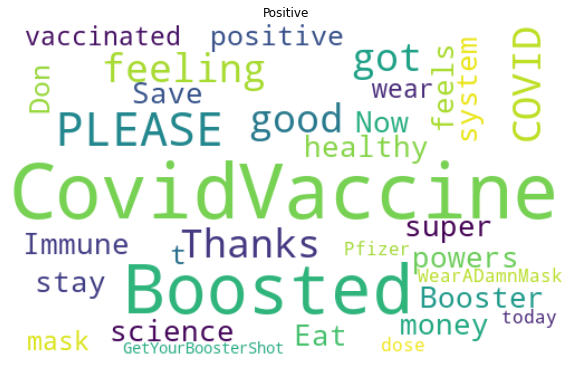

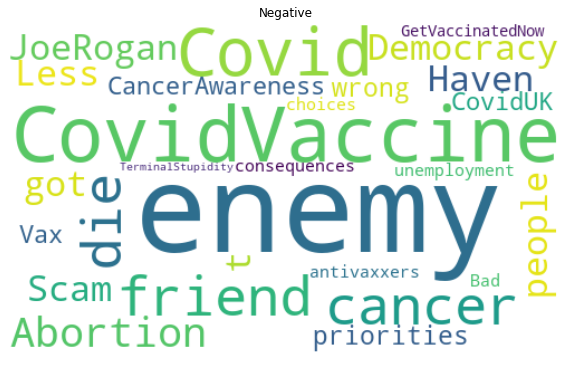

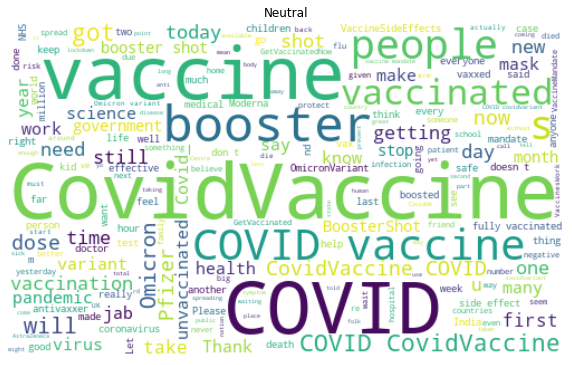

<Figure size 720x720 with 0 Axes>

In [288]:
plt.figure(figsize = (10,10))
# Creating wordclouds for positive, negative, neutral tweets
cloud_of_Words(VADER_positive_tweet, 'Positive')
cloud_of_Words(VADER_negative_tweet, 'Negative')
cloud_of_Words(VADER_neutral_tweet, 'Neutral')

### TEXT BLOB SENTIMENT WORD CLOUD

In [289]:
# categorized tweets 
BLOB_positive_tweet =  sentiment_df[sentiment_df['Text_blob_sentiment'] == 'pos']['Processed_Tweet']
BLOB_negative_tweet =  sentiment_df[sentiment_df['Text_blob_sentiment'] == 'neg']['Processed_Tweet']
BLOB_neutral_tweet =  sentiment_df[sentiment_df['Text_blob_sentiment'] == 'neu']['Processed_Tweet']


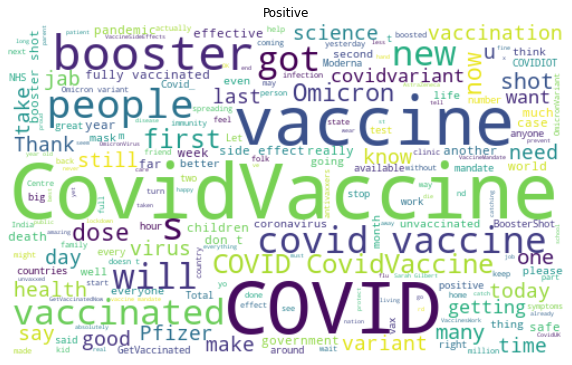

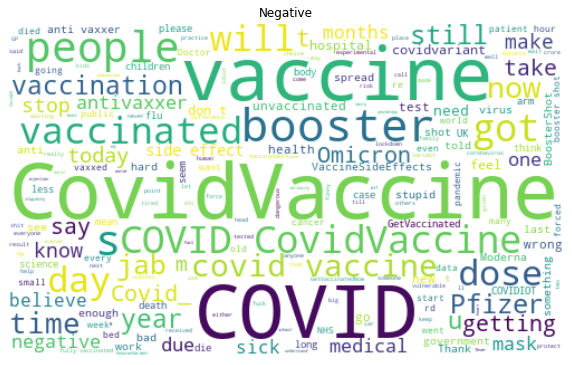

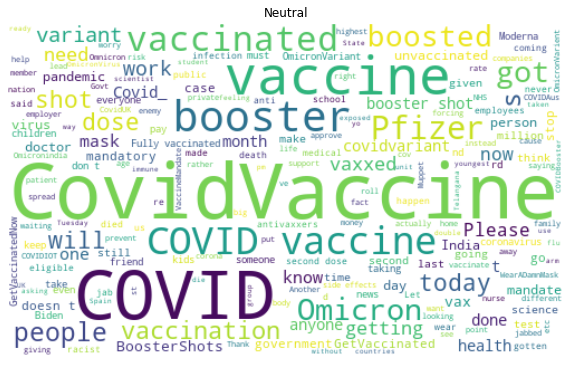

<Figure size 720x720 with 0 Axes>

In [290]:
plt.figure(figsize = (10,10))
# Creating wordclouds for positive, negative, neutral tweets
cloud_of_Words(BLOB_positive_tweet, 'Positive')
cloud_of_Words(BLOB_negative_tweet, 'Negative')
cloud_of_Words(BLOB_neutral_tweet, 'Neutral')

### ROBERTA SENTIMENT WORD CLOUD

In [291]:
RoBERTa_positive_tweet =  sentiment_df[sentiment_df['Roberta_Sentiment'] == 'roberta_pos']['Processed_Tweet']
RoBERTa_negative_tweet =  sentiment_df[sentiment_df['Roberta_Sentiment'] == 'roberta_neg']['Processed_Tweet']
RoBERTa_neutral_tweet =  sentiment_df[sentiment_df['Roberta_Sentiment'] == 'roberta_neu']['Processed_Tweet']


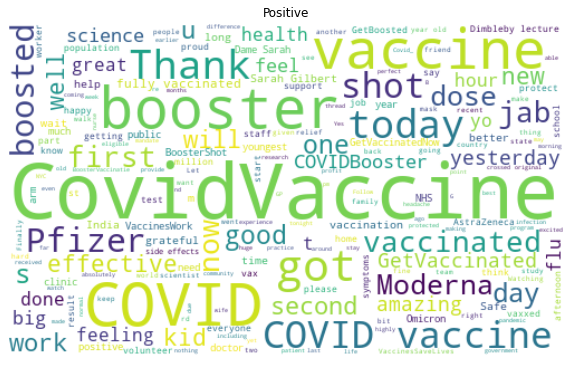

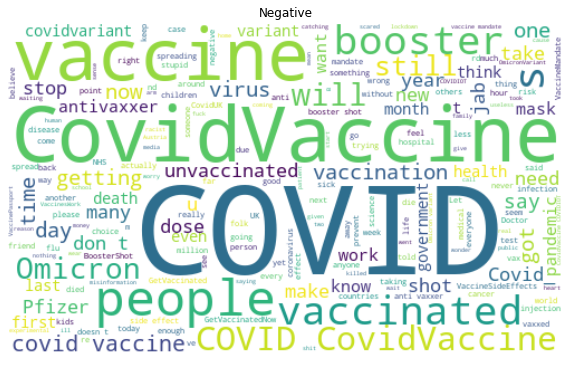

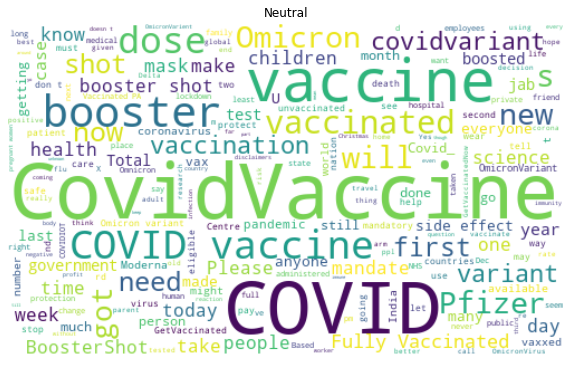

<Figure size 720x720 with 0 Axes>

In [292]:
plt.figure(figsize = (10,10))
# Creating wordclouds for positive, negative, neutral tweets
cloud_of_Words(RoBERTa_positive_tweet, 'Positive')
cloud_of_Words(RoBERTa_negative_tweet, 'Negative')
cloud_of_Words(RoBERTa_neutral_tweet, 'Neutral')

## Manufacturers 

In [293]:
def GetManufacturer(tweet):
    tweet = tweet.lower()
    if 'moderna' in tweet:
        if 'astra' in tweet: 
            return '2'
        elif 'pfizer' in tweet:
            return '2'
        else: 
            return 'mo'
    elif 'pfizer' in tweet:
        if 'astra' in tweet:
            return '2'
        else:
            return 'pf'
    elif 'astra' in tweet:
        return 'az'
    else:
        return '0'

In [294]:
df= sentiment_df['Processed_Tweet'].apply(GetManufacturer)
df.tail()

991     0
992     0
993    pf
994     0
995     0
Name: Processed_Tweet, dtype: object

In [295]:
df

0      pf
1       2
2       0
3       0
4       0
       ..
991     0
992     0
993    pf
994     0
995     0
Name: Processed_Tweet, Length: 996, dtype: object

In [296]:
# creating reference tags for 5 vaccines -> Pfizer, Covaxin(Bharat Biotech), Sputnik,AstraZenca(Covishield),Moderna
pfizer_refs = ["Pfizer","pfizer","Pfizer–BioNTech","pfizer-bioNtech","BioNTech","biontech"]
bbiotech_refs = ["covax","covaxin","Covax","Covaxin","Bharat Biotech","bharat biotech","BharatBiotech","bharatbiotech"]
sputnik_refs = ["russia","sputnik","Sputnik","V"]
astra_refs = ['sii','SII','adar poonawalla','Covishield','covishield','astra','zenca','Oxford–AstraZeneca','astrazenca','oxford-astrazenca','serum institiute']
moderna_refs = ['moderna','Moderna','mRNA-1273','Spikevax']